# Assignment 6: RNN Implementation
-------------------
**Dr. Dave Wanik - University of Connecticut**
A weather-based energy forecasting homework.

* **Your Name Here:** Adam Syed
* **Your NetID Here:** Ads17007

Energy demand forecasting as a function of weather data is an extremely interesting and relevant topic.

I've given you a curated (mostly?) clean dataset that you can use to predict `df['Demand']` as a function of the weather variables.

Of course, you cannot use the df[`Datetime`] column directly into the model - but you can feature engineer the column to make features temporal features for modeling like Julian day of year (0-365), week of year, and number of years since 2012.

**Sorting: (5 pts)**
Sort the data from oldest to newest.

**Cleaning: (10 pts)**
Describe and impute (or drop) the missing values using an appropriate method. At this time, you are welcome to perform feature engineering (optional).

**Process as a 3D tensor: (10 pts)**
Process the data as a 3D tensor with a lookback of your choice (use a value greater than or equal to 12).

**Model Architecure: (10 pts)**
You must use a model with:
* at least two recurrent layers
* at least one convolution layer
* dropout (recurrent or between Dense layers)
* appropriate activation functions

**Experiments: (15 pts each, 30 pts total)**
Freeze the model architecutre and perform a *walk-forward validation* where:
* the first 50k samples predict the remaining ~46k samples
* the first 80k samples predict the remaining ~16k samples

Walk-forward validation is very common to use on the job - it shows how your model (ideally) gets better over time as it gets more data to use. Use subheads

**Evaluation (15 points each, 30 pts total)**
Evaluate your model for each of these experiments - hopefully, your model should improve as you give it more data to use! But that depends on your choice of architecture. You should have:
* quantitative error metrics (mean absolute error and others)
* scatterplots of actual vs. predicted
* time series plots of actual vs. predicted

You should also compare to baseline model like persistence (assume today's energy usage is the same as yesterday's - requires you to shift by 24... ask on discussion board if questions!) or ignore the sequence data and treat this as a 2D problem (a regular supervised learning problem!)

**Conclusions (5 pts total)**
* What did you learn from this assignment? Did your walk-forward validation work as you expected it to?
* What else would you do differently next time?
* At least five great bullets please.

In [284]:
# https://drive.google.com/file/d/1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V/view?usp=sharing
!gdown 1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V

Downloading...
From: https://drive.google.com/uc?id=1xYe3vCKTLeaJKpMDzv57ppCSWK_LCJ5V
To: /Users/adamyeeter/OPIM 5509 Deep Learning/M6 Assignment/BDL_cleanweather_energy (1).csv
100%|██████████████████████████████████████| 7.38M/7.38M [00:00<00:00, 20.4MB/s]


In [285]:
import pandas as pd
df = pd.read_csv('BDL_cleanweather_energy (1).csv')

In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96427 entries, 0 to 96426
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  96427 non-null  object 
 1   Demand    96427 non-null  float64
 2   BDL_tmpf  96160 non-null  float64
 3   BDL_dwpf  96160 non-null  float64
 4   BDL_relh  96160 non-null  float64
 5   BDL_drct  96160 non-null  float64
 6   BDL_sknt  96160 non-null  float64
 7   BDL_p01i  96160 non-null  float64
 8   BDL_alti  96160 non-null  float64
 9   BDL_mslp  96160 non-null  float64
 10  BDL_vsby  96160 non-null  float64
dtypes: float64(10), object(1)
memory usage: 8.1+ MB


In [325]:
#import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Sorting

In [288]:
#convert 'Datetime' to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

#sort by 'Datetime'
df = df.sort_values(by='Datetime')

#display head
print(df.head())

                Datetime  Demand  BDL_tmpf  BDL_dwpf  BDL_relh  BDL_drct  \
8760 2011-01-01 00:00:00  3053.0     33.98     26.96       0.0       0.0   
8761 2011-01-01 01:00:00  2892.0     33.98     26.96       0.0       0.0   
8762 2011-01-01 02:00:00  2774.0     30.92     26.96       0.0       0.0   
8763 2011-01-01 03:00:00  2710.0     30.02     26.06       0.0       0.0   
8764 2011-01-01 04:00:00  2698.0     28.94     24.98       0.0       0.0   

      BDL_sknt  BDL_p01i  BDL_alti  BDL_mslp  BDL_vsby  
8760       0.0       0.0     30.07    1018.5       6.0  
8761       0.0       0.0     30.07    1018.5       6.0  
8762       0.0       0.0     30.07    1018.6       6.0  
8763       0.0       0.0     30.09    1019.2       5.0  
8764       0.0       0.0     30.09    1019.1       5.0  


# Cleaning

In [289]:
#feature engineering
df['hour'] = df['Datetime'].dt.hour
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['month'] = df['Datetime'].dt.month
df['year'] = df['Datetime'].dt.year

#drop 'Datetime' column
df.drop(columns=['Datetime'], inplace=True)

#forward fill NA's
df.fillna(method='ffill', inplace=True)

#check NA's
df.isnull().sum()

Demand       0
BDL_tmpf     0
BDL_dwpf     0
BDL_relh     0
BDL_drct     0
BDL_sknt     0
BDL_p01i     0
BDL_alti     0
BDL_mslp     0
BDL_vsby     0
hour         0
dayofweek    0
dayofyear    0
month        0
year         0
dtype: int64

# Define X and y

In [290]:
#define X and y variables
Y = df[['Demand']]
X = df.drop(axis=1, columns=['Demand'])
print(df.shape, X.shape, Y.shape)

#MinMaxScaler
scaler = MinMaxScaler()

#fit scaler
scaler.fit(X)

#transform 'X'
X_scaled = scaler.transform(X)

(96427, 15) (96427, 14) (96427, 1)


# Process Data

In [292]:
from numpy import array

#split multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in np.arange(len(sequences)):
#find the end of pattern
        end_ix = i + n_steps
#check if beyond dataset
        if end_ix > len(sequences):
            break
#get input and output of pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [293]:
#n_steps
n_steps = 12

#convert df to NumPy array
raw_seq = np.array(df)

#generate dataset for RNN with specified n_steps
X, y = split_sequences(raw_seq, n_steps=12)

In [294]:
#print shape
print(X.shape)
print(y.shape)

(96416, 12, 14)
(96416, 1)


In [295]:
#split data into train and test sets
#50% split
train_pct_index = int(0.5 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

In [296]:
#print shape
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(96416, 12, 14) (48208, 12, 14) (48208, 12, 14)
(96416, 1) (48208, 1) (48208, 1)


# Model Architecure

In [323]:
#n_features
n_features = X_train.shape[2]

#define model
model = Sequential()
#convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
#first recurrent layer
model.add(SimpleRNN(64, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
#second recurrent layer
model.add(SimpleRNN(64, activation='relu'))
model.add(Dropout(0.1))
#output layer
model.add(Dense(1, activation='linear'))

#compile model
model.compile(optimizer='adam', loss='mse')

#model summary
model.summary()

Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 10, 128)           5504      
                                                                 
 max_pooling1d_70 (MaxPooli  (None, 5, 128)            0         
 ng1D)                                                           
                                                                 
 simple_rnn_86 (SimpleRNN)   (None, 5, 64)             12352     
                                                                 
 dropout_140 (Dropout)       (None, 5, 64)             0         
                                                                 
 simple_rnn_87 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dropout_141 (Dropout)       (None, 64)                0         
                                                     

# Experiments

In [312]:
model_1 = Sequential()
model_1.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_1.add(Dropout(0.1))
model_1.add(SimpleRNN(64, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(1, activation='linear'))
model_1.compile(optimizer='adam', loss='mse')

#split for experiment 1
split_point_1 = 50000
X_train_1, y_train_1 = X[:split_point_1], y[:split_point_1]
X_test_1, y_test_1 = X[split_point_1:split_point_1+46416], y[split_point_1:split_point_1+46416]

#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', 
                   patience=5, 
                   verbose=1,
                   restore_best_weights=True)

#fit experiment 1
model_1.fit(X_train_1, y_train_1, 
          epochs=100, 
          batch_size=100, 
          verbose=1,
          callbacks=[es],
          validation_data=(X_test_1, y_test_1))

#store preds
predictions_1 = model_1.predict(X_test_1)

Epoch 1/100
500/500 [==============================] - 6s 9ms/step - loss: 776463.1250 - val_loss: 277152.7812
Epoch 2/100
500/500 [==============================] - 4s 9ms/step - loss: 283885.4375 - val_loss: 196512.1719
Epoch 3/100
500/500 [==============================] - 4s 8ms/step - loss: 190959.7031 - val_loss: 154615.6094
Epoch 4/100
500/500 [==============================] - 3s 7ms/step - loss: 170978.8125 - val_loss: 93766.3750
Epoch 5/100
500/500 [==============================] - 3s 7ms/step - loss: 157801.4531 - val_loss: 102591.6484
Epoch 6/100
500/500 [==============================] - 3s 7ms/step - loss: 142745.3594 - val_loss: 80186.5312
Epoch 7/100
500/500 [==============================] - 4s 7ms/step - loss: 133873.2031 - val_loss: 106292.2500
Epoch 8/100
500/500 [==============================] - 4s 8ms/step - loss: 125656.8125 - val_loss: 59875.4258
Epoch 9/100
500/500 [==============================] - 4s 9ms/step - loss: 115883.9219 - val_loss: 59652.2969
Epoch

In [314]:
model_1 = Sequential()
model_1.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_1.add(Dropout(0.1))
model_1.add(SimpleRNN(64, activation='relu'))
model_1.add(Dropout(0.1))
model_1.add(Dense(1, activation='linear'))
model_1.compile(optimizer='adam', loss='mse')

#split for experiment 2
split_point_2 = 80000
X_train_2, y_train_2 = X[:split_point_2], y[:split_point_2]
X_test_2, y_test_2 = X[split_point_2:split_point_2+16416], y[split_point_2:split_point_2+16416]


#fit experiment 2
model_2.fit(X_train_2, y_train_2, 
          epochs=100, 
          batch_size=100, 
          verbose=1,
          callbacks=[es],
          validation_data=(X_test_2, y_test_2))

#store preds
predictions_2 = model_2.predict(X_test_2)

Epoch 1/100
800/800 [==============================] - 4s 5ms/step - loss: 86613.8750 - val_loss: 64108.7578
Epoch 2/100
800/800 [==============================] - 4s 5ms/step - loss: 87068.5312 - val_loss: 57878.7539
Epoch 3/100
800/800 [==============================] - 4s 5ms/step - loss: 85584.6797 - val_loss: 61323.8984
Epoch 4/100
800/800 [==============================] - 5s 6ms/step - loss: 85006.5312 - val_loss: 71458.8672
Epoch 5/100
800/800 [==============================] - 4s 5ms/step - loss: 85082.9922 - val_loss: 64342.7617
Epoch 6/100
800/800 [==============================] - 4s 5ms/step - loss: 85676.9688 - val_loss: 43637.7617
Epoch 7/100
800/800 [==============================] - 5s 6ms/step - loss: 83789.4219 - val_loss: 72781.0312
Epoch 8/100
800/800 [==============================] - 4s 5ms/step - loss: 84322.0781 - val_loss: 46465.4648
Epoch 9/100
800/800 [==============================] - 4s 5ms/step - loss: 84223.3047 - val_loss: 73920.7031
Epoch 10/100
800/80

# Model Evaluation

### Experiment 1

In [315]:
#experiment 1 evaluation
mae_1 = mean_absolute_error(y_test_1, predictions_1)
mse_1 = mean_squared_error(y_test_1, predictions_1)
rmse_1 = np.sqrt(mse_1)

mae_1, mse_1, rmse_1

(156.24326158031107, 43754.27409938325, 209.17522343571966)

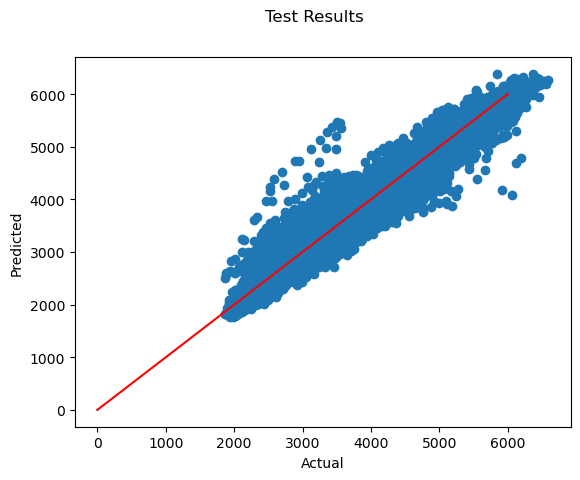

In [316]:
#scatterplot actual vs. pred experiment 1
actual_1 = y_test_1
plt.scatter(x=actual_1, y=predictions_1)

#45 degree line
x = np.linspace(0,6000)

plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

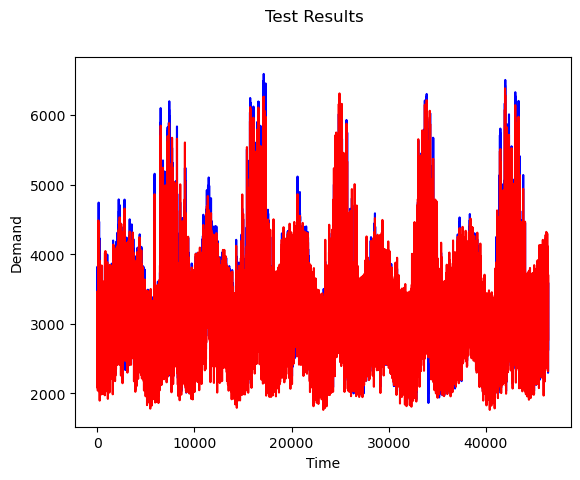

In [320]:
#time series plot experiment 1
plt.plot(np.arange(X_test_1.shape[0]), y_test_1, color='blue')
plt.plot(np.arange(X_test_1.shape[0]), predictions_1, color='red')
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

### Experiment 2

In [317]:
#experiment 2 evaluation
mae_2 = mean_absolute_error(y_test_2, predictions_2)
mse_2 = mean_squared_error(y_test_2, predictions_2)
rmse_2 = np.sqrt(mse_2)

mae_2, mse_2, rmse_2

(156.83019855158693, 43637.7660937023, 208.8965439965494)

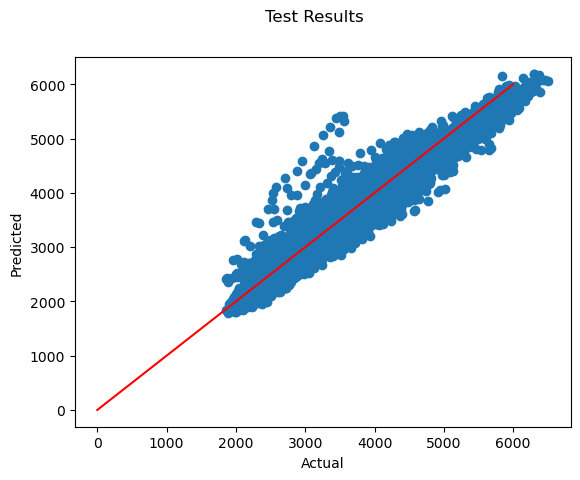

In [318]:
#scatterplot actual vs. pred experiment 2
actual_2 = y_test_2
plt.scatter(x=actual_2, y=predictions_2)

#45 degree line
x = np.linspace(0,6000)

plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

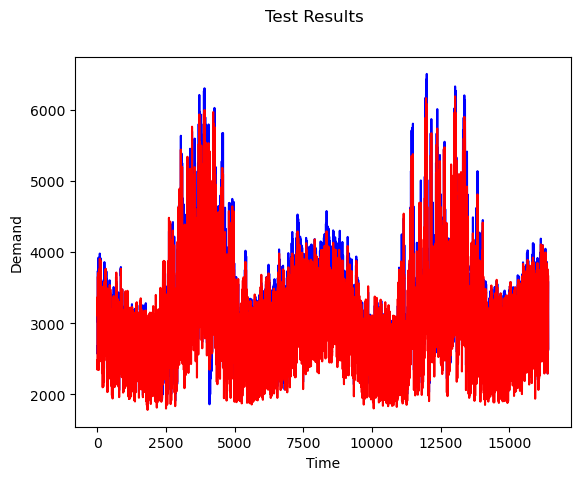

In [321]:
#time series plot experiment 2
plt.plot(np.arange(X_test_2.shape[0]), y_test_2, color='blue')
plt.plot(np.arange(X_test_2.shape[0]), predictions_2, color='red')
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

# Conclusion

1. One thing I learned is how to use feature engineering to extract meaningful variables from a datetime variable. I was able to extract 'hour', 'dayofweek', 'dayofyear', 'month', and 'year'.

2. Another thing I learned is how to display a time series plot. This is a good way to visualize the model's performance over time.

3. Another thing I learned is how to split the data at a certain number of samples instead of doing a percentile split. This helped me with the walk-forward validation part of the assignment. 

4. Yes, my walk-forward validation did work as expected. The results from the walk-forward validation improved slightly from experiment 1 to experiment 2. Experiment 2 had a very slighly worse mae than experiment one but had a slightly better mse and rmse than experiment 1. 

5. Next time I would experiment more with different model architectures. For example, I would experiment with different reccurent units like LSTM or GRU instead of just SimpleRNN. Also, next time I could incorporate bidirectional layers to capture dependencies in both directions.